In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
# Simple dataset for loading images and labels
class BlurDataset(Dataset):
    def __init__(self, image_folder, dir_names=['Sharp', 'Blur'],transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = []
        self.labels = []
        for label, folder in enumerate(dir_names):
            folder_path = os.path.join(image_folder, folder)
            for img_file in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Updated CNN model with additional conv layers and reduced linear layers
class BlurDetectionModel(nn.Module):
    def __init__(self):
        super(BlurDetectionModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 64),  # Reduced linear layer size to prevent overfitting
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 classes: sharp and blur
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = x1.view(x1.size(0), -1)
        x3 = self.classifier(x2)
        return x,x2,x3
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, epoch, dataset_type="Validation"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sharp', 'Blur'], yticklabels=['Sharp', 'Blur'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.title(f'{dataset_type} Confusion Matrix - Epoch {epoch + 1}')
    plt.title("Image Quality Classification Results")
    filename = "img_qual_classification_results.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # High resolution + tight layout
    plt.show()
    
# Evaluation function for validation data
def evaluate_model(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs[2], labels)
            val_loss += loss.item() * images.size(0)
            #print(outputs)
            preds = torch.argmax(outputs[2], dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss after Epoch [{epoch+1}]: {val_loss:.4f}')
    plot_confusion_matrix(all_labels, all_preds, epoch, dataset_type="Validation")
    model.train()

# Training loop with validation evaluation after each epoch
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs[2], labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs[2], dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}')

        # Plot training confusion matrix after each epoch
        plot_confusion_matrix(all_labels, all_preds, epoch, dataset_type="Training")

        # Evaluate on validation dataset
        evaluate_model(model, val_loader, criterion, device, epoch)

Epoch [1/3], Training Loss: 0.2910


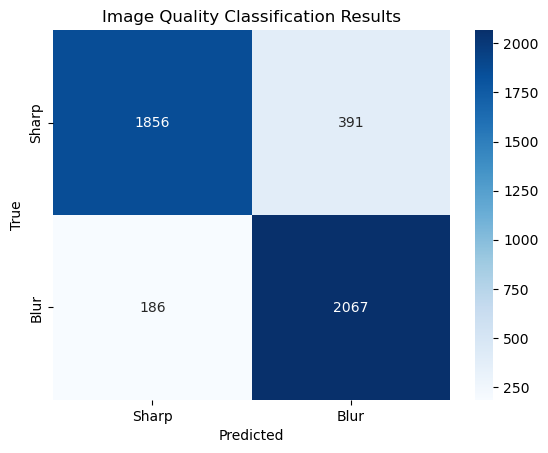

Validation Loss after Epoch [1]: 0.5345


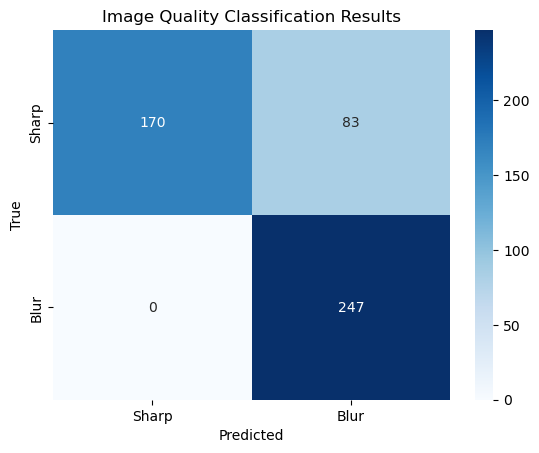

Epoch [2/3], Training Loss: 0.1231


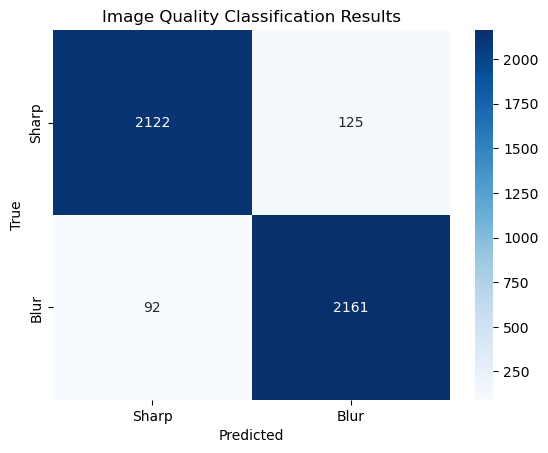

Validation Loss after Epoch [2]: 0.0485


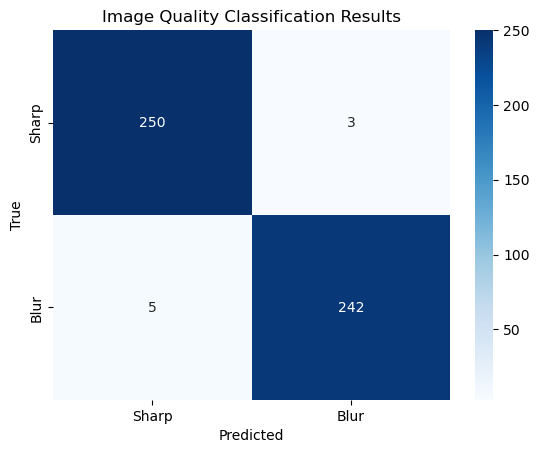

Epoch [3/3], Training Loss: 0.0325


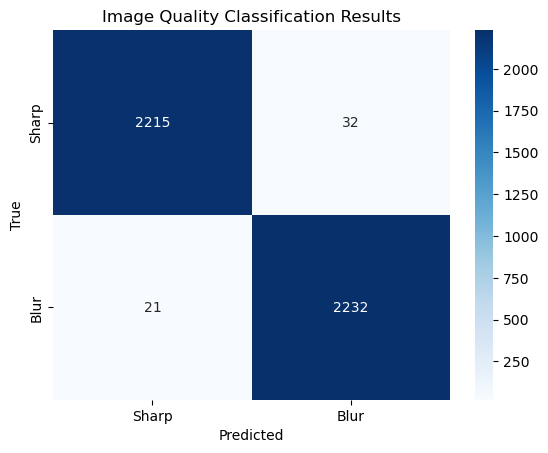

Validation Loss after Epoch [3]: 0.0355


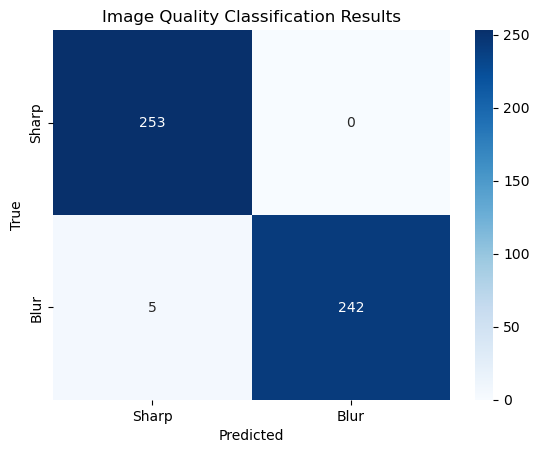

Model saved as 'blur_detection_model_norm.pth'


In [2]:
    image_folder = "C:\\Users\\preet\\Documents\\BRSET\\data\\BlurDetector\\Train"  # Dataset should have 'sharp' and 'blur' subfolders
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 3
    val_split = 0.1
    NORM_MEAN = [0.485, 0.456, 0.406]
    NORM_STD = [0.229, 0.224, 0.225]

    # Independent transformations for train and validation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
       # transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ])

    # Dataset and DataLoader
    dataset = BlurDataset(image_folder,  ['Blur','Sharp'],transform=None)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Apply independent transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss function, optimizer
    model = BlurDetectionModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

    # Saving the model
    torch.save(model.state_dict(), "blur_detection_model.pth")
    print("Model saved as 'blur_detection_model.pth'")


Validation Loss after Epoch [1]: 0.0000


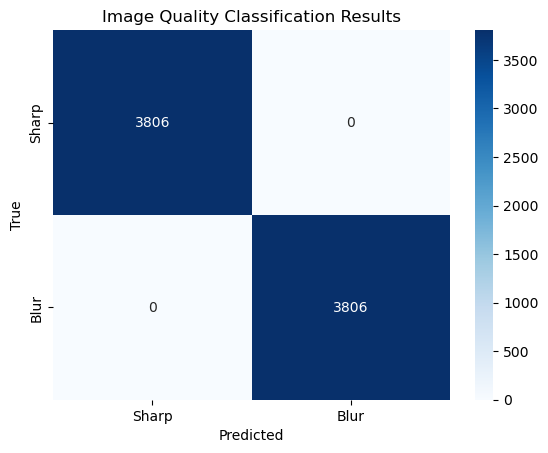

In [14]:
state_dict = torch.load("blur_detection_model.pth")
model = BlurDetectionModel()
criterion = nn.CrossEntropyLoss()
batch_size = 16

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(state_dict,strict=True)
model.eval()
model=model.cuda()
image_folder = "C:\\Users\\preet\\Documents\\BRSET\\data\\BlurDetector\\Test"  # Dataset should have 'sharp' and 'blur' subfolders
val_dataset = BlurDataset(image_folder, ['Blur','Sharp'], transform=None)
val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
       #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ])

# Apply independent transforms
val_dataset.transform = val_transform

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
evaluate_model(model, val_loader, criterion, device, epoch=0)